In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
from torch import optim
from env import VanillaEnv
from rl.common.utils import set_seed
import time
from policy import ActorNet

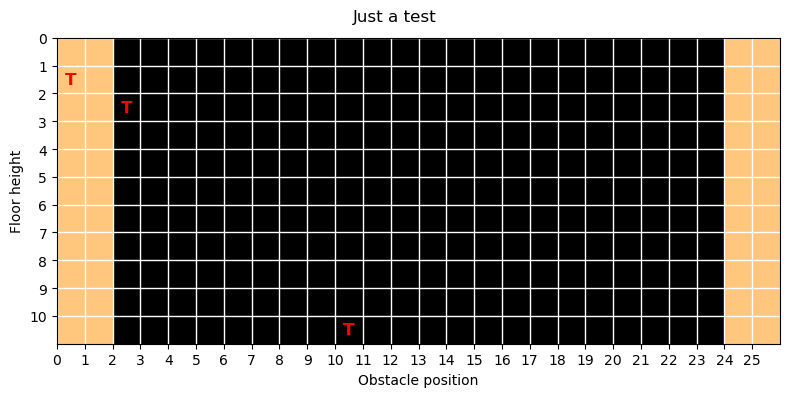

In [22]:
def plot_evaluation_grid(grid, training_positions):
    """Plots the evaluation grid."""
    fig, ax = plt.subplots(figsize=(8, 4))
    grid_x, grid_y = grid.shape
    extent = (0, grid_x, grid_y, 0)
    ax.imshow(grid.T, extent=extent, origin='lower', cmap='copper')

    x_ticks = np.arange(grid_x)
    y_ticks = np.arange(grid_y)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_ylabel("Floor height")
    ax.set_xlabel("Obstacle position")
    
    # Loop over data dimensions and create text annotations.
    for (obstacle_pos, floor_height) in training_positions:
        pos_index = obstacle_pos
        height_index = floor_height
        ax.text(
            pos_index + 0.5,
            height_index + 0.5,
            'T',
            ha='center',
            va='center',
            color='r',
            fontsize='large',
            fontweight = 'bold')

    ax.grid(color='w', linewidth=1)
    fig.tight_layout()
    return fig

n_obstacle_pos = 26 # how many obstacle position you want to try out (paper: 27, max: 30)
n_floor_heights = 11 # how many floor heights you want to try out (paper: 11, max: 40)
obstacle_pos = np.rint(np.linspace(VanillaEnv.min_obstacle_pos, VanillaEnv.max_obstacle_pos, n_obstacle_pos)).astype(np.int8)
floor_height = np.rint(np.linspace(VanillaEnv.min_floor_height, VanillaEnv.max_floor_height, n_floor_heights)).astype(np.int8)

grid = np.zeros((len(obstacle_pos), len(floor_height)))

grid[1] = np.ones(11)
grid[0] = np.ones(11)
grid[-1] = np.ones(11)
grid[-2] = np.ones(11)

fig = plot_evaluation_grid(grid, [(0, 1), [2,2], [10,10]])
fig.suptitle("Just a test")
plt.show()


In [23]:
def map_conf_to_index(confs:list)->list:
    """
    Takes a list of configurations (i.e.: [(14, 0), (25, 20)]) and returns the 
    indices that correspond to the grid (i.e.: [(0, 0), (8,5)])
    """
    res = []
    for conf in confs:
        x = np.where(obstacle_pos == conf[0])[0]
        y = np.where(floor_height == conf[1])[0]
        assert len(x) == 1 and len(y) == 1, "Something wrong with the grid. Make sure the configurations are defined equally while training & evaluating"
        res.append((x[0], y[0]))
    return res

Loading model  loss_combined-bc.pth


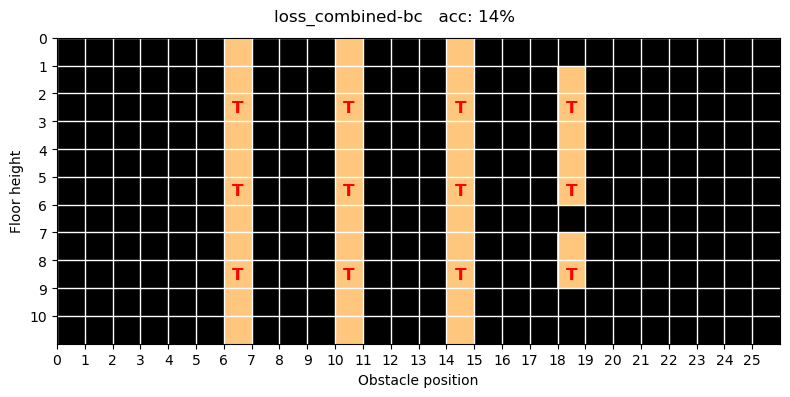

Loading model  loss_my_psm_fb_yx-bc.pth


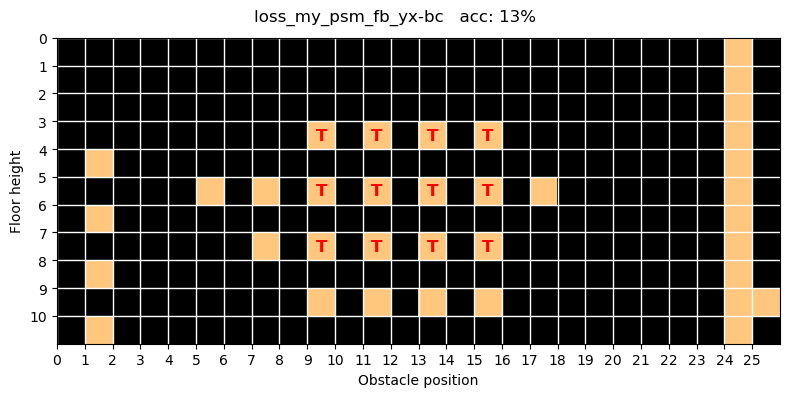

Loading model  loss_my_psm_paper_yx-bc.pth


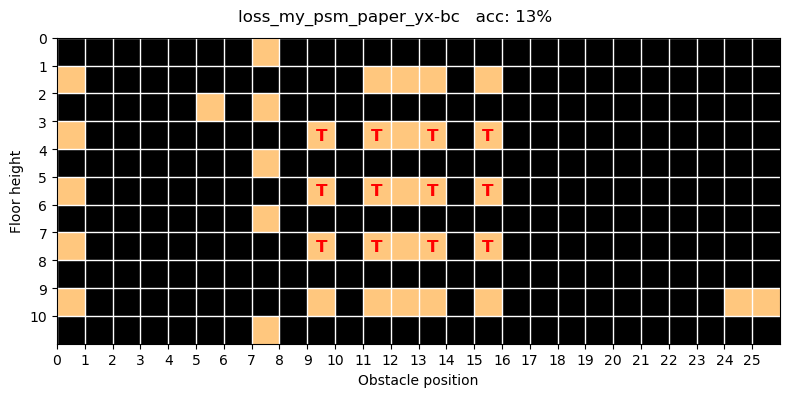

Loading model  loss_paper_psm_fb_xy-bc.pth


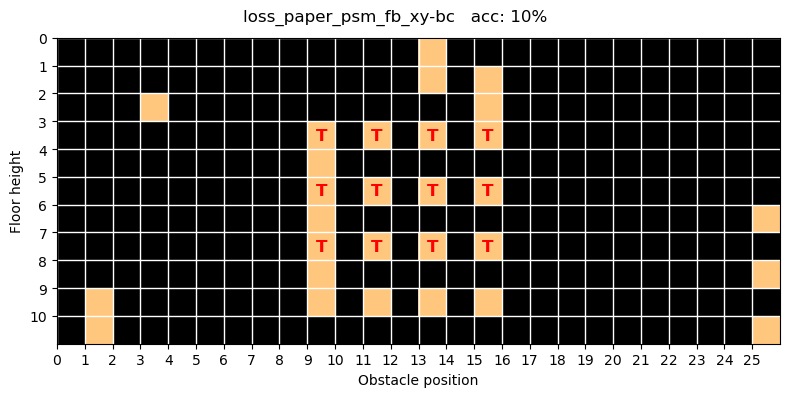

Loading model  loss_paper_psm_fb_yx-bc.pth


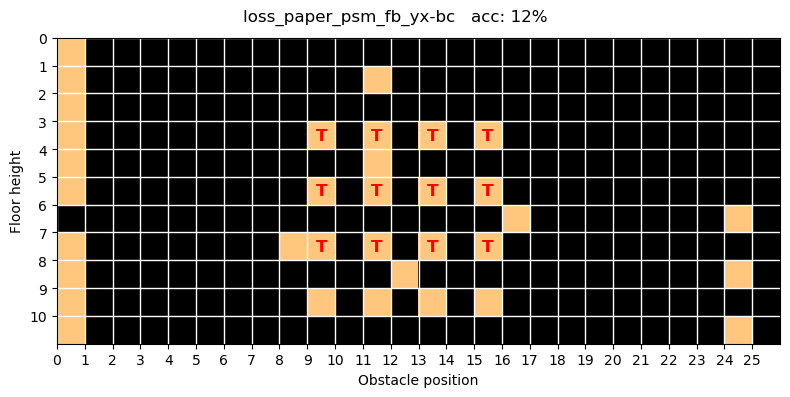

Loading model  loss_paper_psm_paper_xy-bc.pth


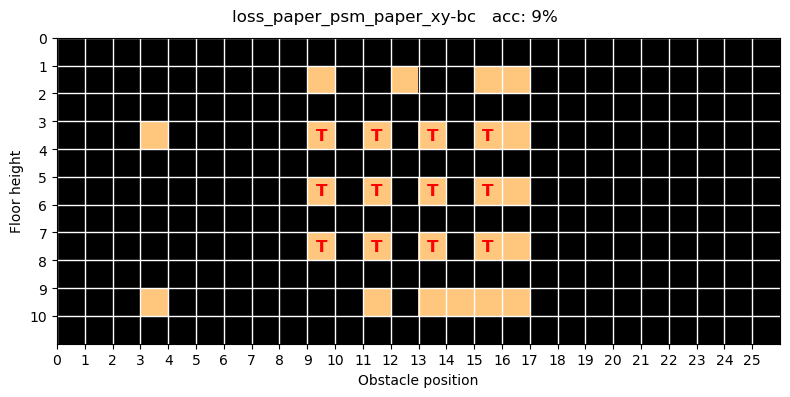

Loading model  loss_paper_psm_paper_yx-bc.pth


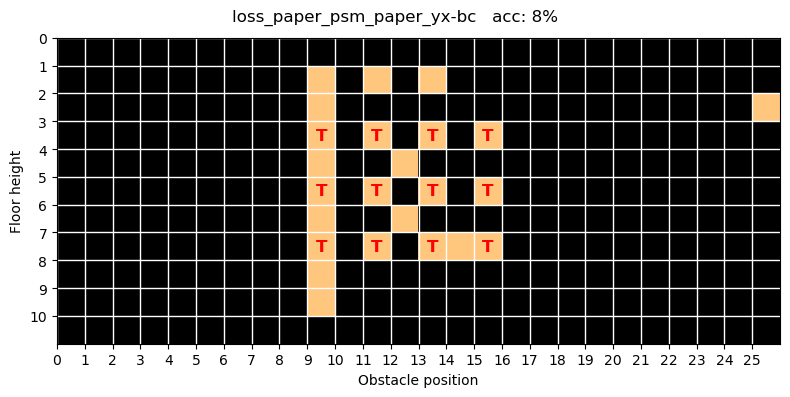

Loading model  loss_wide_paper_psm_paper_yx-bc.pth


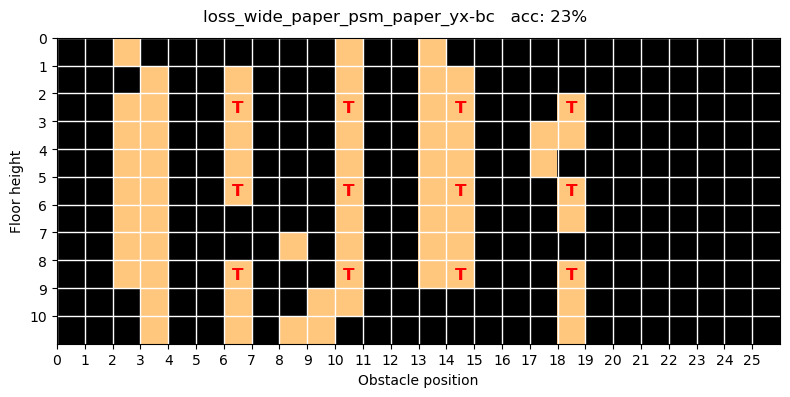

Loading model  without_contrastive-bc.pth


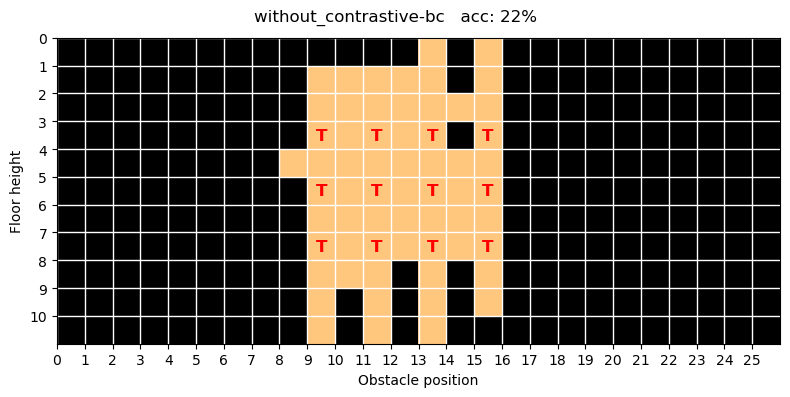

In [24]:
render = False
folder_name: str = './ckpts/'

def play_episode(model: ActorNet, env: VanillaEnv)->bool:
    """
    returns true of the episode is concidered solved
    """
    done = False
    episode_return = 0
    obs = env.reset()
    while not done:
        action_logits = model.forward(torch.FloatTensor(obs).unsqueeze(0), contrastive=False)
        action = torch.argmax(action_logits)
        obs, rewards, done, info = env.step(action.item())
        episode_return += rewards
        if render: env.render()
    return not info['collision']

for conf_name in os.listdir(folder_name):
    if not conf_name.endswith('.pth'): continue
    if not 'bc' in conf_name: continue
    img_name = conf_name.replace('.pth', '-eval.png')

    # check if the file already exists
    # if img_name in os.listdir(folder_name): continue
    
    print("Loading model ", conf_name)
    grid = np.zeros((len(obstacle_pos), len(floor_height)))

    solved_counter, failed_counter = 0,0

    for obs_pos_idx in range(len(obstacle_pos)):
        for floor_height_idx in range(len(floor_height)):
            curr_obs_pos = obstacle_pos[obs_pos_idx]
            curr_floor_height = floor_height[floor_height_idx]

            # todo load the model and check performance for all configurations
            env = VanillaEnv([(curr_obs_pos, curr_floor_height),], rendering=render)
            set_seed(env, 31)


            model = ActorNet()
            ckp = torch.load(folder_name + conf_name)
            model.load_state_dict(ckp['state_dict'])
            train_info = ckp['info']


            for _ in range(1):
                is_solved = play_episode(model, env)
                if is_solved: 
                    grid[obs_pos_idx][floor_height_idx] += 1
                    solved_counter += 1
                else:
                    failed_counter += 1

    acc = round(solved_counter * 100 / (solved_counter + failed_counter))
    fig = plot_evaluation_grid(np.fliplr(grid), map_conf_to_index(train_info['conf']))
    fig.suptitle(conf_name.replace('.pth', '') + f"   acc: {acc}%")
    plt.savefig(folder_name + img_name)
    plt.show()